# Altitude Data Engineering
Geo vis group - predicting sea level rise

Overview:

- **get_gdal** Given a latitude / longitude (gps) coordinate pair, download the corresponding GDAL image of the geography.
    - if needed, make multiple smaller requests in order to download entire dataset, and combine them into one
- **map_altitudes** Given a GDAL image and X altitude ranges (eg: 0 - 10 meters, 10 - 20 meters, etc.), output polygon shape coordinates on the map for the given altitude ranges.
    - keep GPS coordinates in final polygon dataset
    - Idea: Multipass sparse matrix with convolutions
- **combine_polygons** Given two polygons and their gps coordinates, combine them into a single shape with gps coordinates loadable into mapbox. 



In [102]:
#example to download packages
#import sys
#!{sys.executable} -m pip install elevation

In [120]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import elevation 
import scipy as scipy

In [179]:
#See: https://github.com/bopen/elevation
#or run: 
#eio clip -o Hawaii.tif --bounds -156.09 19.00 -154.81 20.26

#the format is: 
#eio clip -o Hawaii.tif --bounds long1 lat1 long2 lat2
# Below we have long1 -156.70 and lat1 20.78

#
#!eio clip -o data/maui_001.tif --bounds -156.70 20.83 -155.00 22.00
#!eio clip -o data/Rome-30m-DEM.tif --bounds 12.35 41.8 12.65 42

# downtown section of the seattle waterfront
#!eio clip -o data/seattle_dt_001.tif --bounds -122.36 47.59 -122.33 47.62

#larger slice of downtown area
#!eio clip -o data/seattle_dt_002.tif --bounds -122.39 47.59 -122.32 47.63

#greater seattle area
#!eio clip -o data/seattle_gt_003.tif --bounds -122.44 47.51 -122.24 47.71

#seattle large area
#todo

#arlington
!eio clip -o data/arlington_001.tif --bounds -122.10 48.17 -122.07 48.19

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.f11a0851116a42eb8e06bd47cc42cee7.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -122.44 47.71 -122.24 47.51 SRTM1.f11a0851116a42eb8e06bd47cc42cee7.vrt /Users/blakedallen/go/src/github.com/blakedallen/MIDS/W209/geo-viz-group/data/seattle_gt_003.tif
rm -f SRTM1.f11a0851116a42eb8e06bd47cc42cee7.vrt
curl -s -o spool/N48/N48W123.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/N48/N48W123.hgt.gz && mv spool/N48/N48W123.hgt.gz.temp spool/N48/N48W123.hgt.gz
gunzip spool/N48/N48W123.hgt.gz 2>/dev/null || touch spool/N48/N48W123.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/N48/N48W123.hgt cache/N48/N48W123.tif 2>/dev/null || touch cache/N48/N48W123.tif
rm spool/N48/N48W123.hgt
gdalbuildvrt -q -overwrite SRTM1.vrt cache/N41/N41W123.tif cache/N41/N41W122.tif cache/N41/N41E012.tif cache/N48/N48W

In [185]:
#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26
filename = "data/seattle_gt_003.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

print(data_array.shape)

#i,j
#longtitude -156.70 --> -156.00
#latitude   20.83 --> 21.00
data_array = np.flip(data_array, axis=0)

#save to csv
#np.savetxt("data/locations/hawaii_big_island.csv", data_array, delimiter=",")


sliced = []
for x in range(0,data_array.shape[0],100):
    sliced_x = []
    for y in range(0,data_array.shape[1],100):
        #print(data_array[x][y])
        sliced_x.append(data_array[x][y])
    sliced.append(sliced_x)

(720, 720)


In [188]:
lower = -200
upper = 140
step = 10
levels = list(range(lower, upper, step))
print(levels)

[-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]


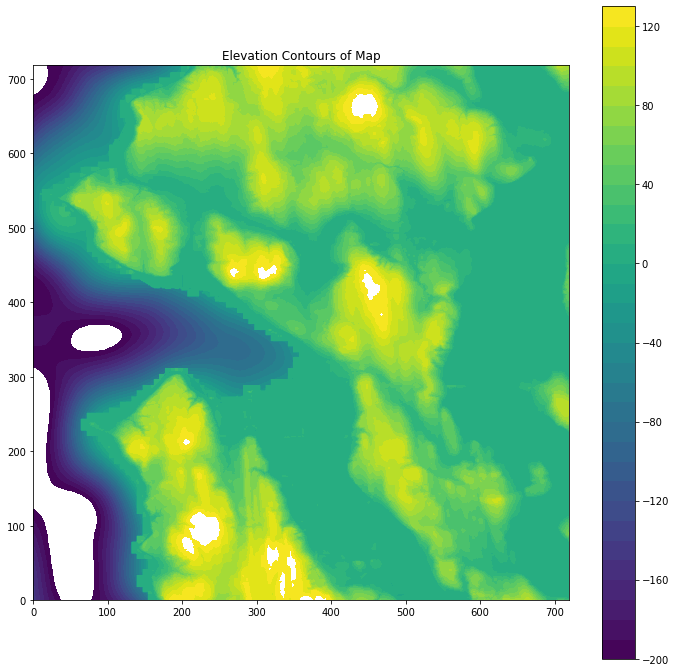

In [189]:
#Plot our data with Matplotlib's 'contourf'
%matplotlib inline
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Map")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [116]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)



def toGEO(i,j, bottom_left, top_right):
    """ given an i,j index, will return (lon,lat,elevation)"""
    ele = data_array[i][j]
    lon = translate(i, 0, data_array.shape[0], bottom_left[0], top_right[0])
    lat = translate(j, 0, data_array.shape[1], bottom_left[1], top_right[1])
    return (lon,lat,ele)

def toSparse(arr, cutoff=(0.0,10.0), char=1, nan=0):
    """ given a 1d array and cutoff will create a sparse matrix
        representation of the array based on the cutoff range
        Note: cutoff range is by default inclusive on the lower value [x,y)
    """
    def mapTo(elem, cutoff, char, nan):
        if elem < cutoff[0]:
            return nan
        elif elem >= cutoff[1]:
            return nan
        else:
            return char
    sparse = [mapTo(elem, cutoff, char, nan) for elem in arr]
    return np.array(sparse)


In [194]:
#create a dataset for each level
#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26

#TODO, create custom rects for each of these 
#elevations
#export these as datasets (geocoordinates)

matrices = {} #mapping of level range "0-10" --> <sparse matrix>

for level in levels:
    ll = level
    ul = level + step
    sparse_matrix = []
    for row in data_array:
        sparse_row = toSparse(row, cutoff=(ll, ul))
        sparse_matrix.insert(0, sparse_row)
    sm = np.asarray(sparse_matrix)
    key = str(ll)+"-"+str(ul)
    matrices[key] = sm



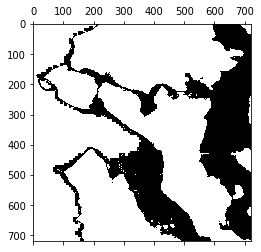

In [201]:
#Plot our sparse matrix to see results
plt.spy(matrices["0-10"])

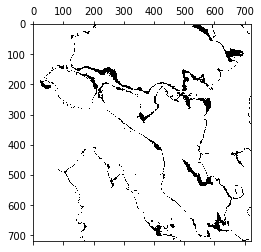

In [196]:
plt.spy(matrices["10-20"])

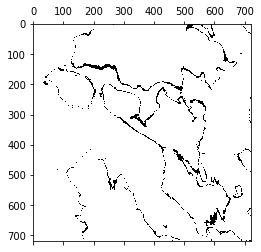

In [197]:
plt.spy(matrices["20-30"])

In [136]:
#PLOT SHAPE USING POLYGONS
# from matplotlib.collections import PatchCollection
# from matplotlib.patches import Polygon


# patches = []
# colors = []
# #example = [[[0,1],[0,2],[2,2]], [[1,1],[1,2],[3,2]] ]

# for s in polys:
#     patches.append(Polygon(s))

# fig, ax = plt.subplots()
# p = PatchCollection(patches, alpha=0.25)
# ax.add_collection(p)
# ax.autoscale()
# plt.show()

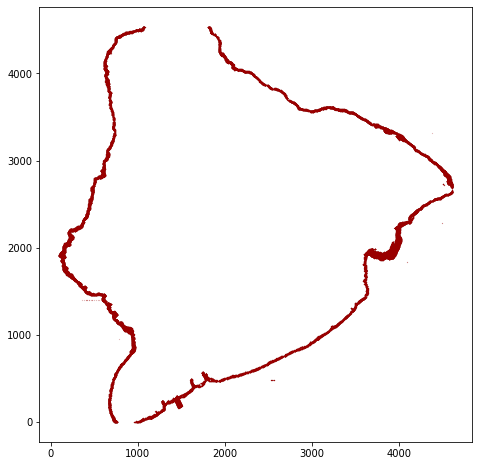

In [101]:
#PLOT ALL POINTS BY LEVEL
colors = [
    "#ffffd9",
    "#edf8b1",
    "#c7e9b4",
    "#7fcdbb",
    "#41b6c4",
    "#1d91c0",
    "#225ea8",
    "#0c2c84",
]
colors2 = [
"#fff7ec",
"#fee8c8",
"#fdd49e",
"#fdbb84",
"#fc8d59",
"#ef6548",
"#d7301f",
"#990000",
]
colors.reverse()
colors2.reverse()

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

for i,l in enumerate(levels):
    if i > 0:
        break
    data_x = [x[0] for x in level_xy[l]]
    data_y = [x[1] for x in level_xy[l]]
    plt.scatter(data_x,data_y, s=0.01, c=colors2[i])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()
